<div style="background-color: rgb(150, 50, 50);">
The goal is to change this, from the correspnding -cpu file, to the IPU accelerator.
</div>

The main code is taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and is covered by the licence in the correspondig Githib repository, reproduced the accomanying file here, PYTORCH_EXAMPLES_LIBRARY.

This file has been modified following the instructions at [Pytorch to Poptorch](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/pytorch_to_poptorch.html?highlight=pytorch%20to%20poptorch) ... 

In [1]:
import time
event_times = [("Start", time.time())]

In [2]:
import torch
import poptorch  
import torchvision
import torchvision.transforms as transforms
event_times.append(("Torch imports done", time.time()))

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
opts = poptorch.Options()
devIterations = 100
opts.deviceIterations(devIterations)  # ??? what does this do
trainloader = poptorch.DataLoader(options=opts, dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = poptorch.DataLoader(options=opts, dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
event_times.append(("Data loaders created", time.time()))

Files already downloaded and verified
Files already downloaded and verified


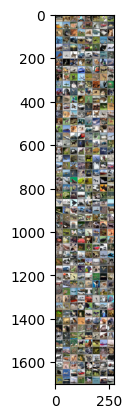

plane dog   bird  plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
event_times.append(("Training batch displayed", time.time()))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # This model has no final max - see below - loss crtierion is CrossEntropy so inlcudes a SoftMax and prediction uses max

class PoptorchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Net()
    
    def forward(self, input, target=None):  # No target when evaluating
        out = self.model(input)
        # https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/pytorch_to_poptorch.html?highlight=pytorch%20to%20poptorch#training
        # adds a target parameter
        # also compare https://docs.graphcore.ai/projects/tutorials/en/latest/pytorch/basics/README.html#build-the-model
        if self.training:
            return (torch.nn.functional.softmax(out),
                    torch.nn.CrossEntropyLoss(reduction="mean")(out, target))
        return out  # because prediction below uses a max on this output
    
poptorch_net = PoptorchNet()

event_times.append(("Base model declared", time.time()))

In [6]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()  # because is specified in the model
optimizer = optim.SGD(poptorch_net.parameters(), lr=0.001, momentum=0.9)

event_times.append(("Optimzer declared", time.time()))

poptorch_training_model = poptorch.trainingModel(poptorch_net, options=opts, optimizer=optimizer)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # For what popTorch.trainingModel does for you in the training loop
        # see https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/pytorch_to_poptorch.html?highlight=pytorch#the-training-loop
        # zero the parameter gradients
        # optimizer.zero_grad() 

        # forward + backward + optimize
        outputs, loss = poptorch_training_model(inputs,labels)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % (2000 // devIterations) == 2000 // devIterations - 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {(i + 1) * batch_size * devIterations:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            event_times.append((f'Epoch {epoch + 1}, Image {(i + 1) * batch_size * devIterations:5d} trained', time.time()))

print('Finished Training')
event_times.append(("Training complete (inluding complilation)", time.time()))

[14:09:34.313] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 12
/tmp/ipykernel_433850/1568631409.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return (torch.nn.functional.softmax(out),
Graph compilation: 100%|██████████| 100/100 [00:20<00:00]


[1,  8000] loss: 0.022
[1, 16000] loss: 0.019
[1, 24000] loss: 0.018
[1, 32000] loss: 0.016
[1, 40000] loss: 0.014
[1, 48000] loss: 0.017
[2,  8000] loss: 0.013
[2, 16000] loss: 0.014
[2, 24000] loss: 0.013
[2, 32000] loss: 0.015
[2, 40000] loss: 0.014
[2, 48000] loss: 0.012
Finished Training


In [8]:

PATH = './cifar_net_graphcore.pth'
torch.save(poptorch_net.state_dict(), PATH)
event_times.append(("Model saved", time.time()))

/home/ucapcjg/pythonenvs/cifar/lib64/python3.9/site-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


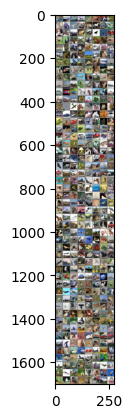

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
event_times.append(("Test batch displayed", time.time()))

In [10]:

poptorchNet = PoptorchNet()
inferenceNet = poptorch.inferenceModel(poptorchNet)  
inferenceNet.load_state_dict(torch.load(PATH))
inferenceNet.eval()
event_times.append(("Model loaded", time.time()))

In [11]:
outputs = inferenceNet(images)
event_times.append(("Test images evaluated (including compilation)", time.time()))

Graph compilation: 100%|██████████| 100/100 [00:27<00:00]


In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
event_times.append(("Test image classes displayed", time.time()))

Predicted:  cat   car   ship  ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = inferenceNet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
event_times.append(("Test image class accuracy", time.time()))

Accuracy of the network on the 10000 test images: 55 %


In [14]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = inferenceNet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

event_times.append(("Test image accuracy by class", time.time()))

Accuracy for class: plane is 65.5 %
Accuracy for class: car   is 74.4 %
Accuracy for class: bird  is 29.1 %
Accuracy for class: cat   is 54.2 %
Accuracy for class: deer  is 54.1 %
Accuracy for class: dog   is 34.1 %
Accuracy for class: frog  is 54.8 %
Accuracy for class: horse is 56.4 %
Accuracy for class: ship  is 64.3 %
Accuracy for class: truck is 68.5 %


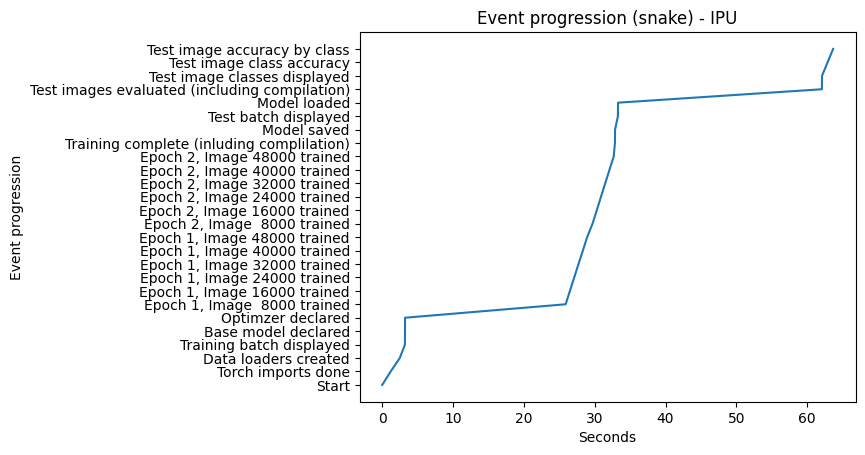

In [15]:
import json
event_times = [(label, event_time - event_times[0][1]) for label, event_time in event_times]
with open("times_ipu_deviter{}.json".format(devIterations), "w") as f:
    json.dump(event_times, f)

import matplotlib.pyplot as plt
labels, times = list(zip(*event_times))
x = times
y = list(range(len(labels)))

plt.plot(x, y)
plt.title("Event progression (snake) - IPU")
plt.xlabel('Seconds')
plt.ylabel('Event progression')
plt.yticks(ticks=y, labels=labels)
plt.show()
